# PROJET 4
# MODELISATION CIBLE 2
***

## 1 - PREPROCESSING
***

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
import xgboost as xgb

In [13]:
#On importe les dataframes issus de notre nettoyage

data_ghg = pd.read_csv('data/data_ghg.csv')
data_ghgstar = pd.read_csv('data/data_ghgstar.csv')

In [15]:
data_ghg.head()

,PrimaryPropertyType,Neighborhood,NumberofBuildings,PropertyGFATotal,LargestPropertyUseType,SecondLargestPropertyUseType,TotalGHGEmissions,ElectricityProp,SteamProp,GasProp,Age,BuildingArea,ParkingArea,LargestUsedArea,SecondLargestUsedArea
0,Hotel,DOWNTOWN,1.0,88434,Hotel,NONE,249.98,0.546060,0.277302,0.176638,89,1.000000,0.000000,1.000000,0.000000
1,Hotel,DOWNTOWN,1.0,103566,Hotel,Parking,295.86,0.386609,0.000000,0.613391,20,0.854547,0.145453,0.809918,0.145453
2,Hotel,DOWNTOWN,1.0,956110,Hotel,NONE,2089.28,0.682307,0.297113,0.020579,47,0.794252,0.205748,0.791220,0.000000
3,Hotel,DOWNTOWN,1.0,61320,Hotel,NONE,286.43,0.407519,0.325913,0.266567,90,1.000000,0.000000,1.000000,0.000000
4,Hotel,DOWNTOWN,1.0,175580,Hotel,Parking,505.01,0.378802,0.000000,0.621198,36,0.646885,0.353115,0.703070,0.387339


In [17]:
data_ghgstar.head()

,PrimaryPropertyType,Neighborhood,NumberofBuildings,PropertyGFATotal,LargestPropertyUseType,SecondLargestPropertyUseType,ENERGYSTARScore,TotalGHGEmissions,ElectricityProp,SteamProp,GasProp,Age,BuildingArea,ParkingArea,LargestUsedArea,SecondLargestUsedArea
0,Hotel,DOWNTOWN,1.0,88434,Hotel,NONE,60.0,249.98,0.546060,0.277302,0.176638,89,1.000000,0.000000,1.000000,0.000000
1,Hotel,DOWNTOWN,1.0,103566,Hotel,Parking,61.0,295.86,0.386609,0.000000,0.613391,20,0.854547,0.145453,0.809918,0.145453
2,Hotel,DOWNTOWN,1.0,956110,Hotel,NONE,43.0,2089.28,0.682307,0.297113,0.020579,47,0.794252,0.205748,0.791220,0.000000
3,Hotel,DOWNTOWN,1.0,61320,Hotel,NONE,56.0,286.43,0.407519,0.325913,0.266567,90,1.000000,0.000000,1.000000,0.000000
4,Hotel,DOWNTOWN,1.0,175580,Hotel,Parking,75.0,505.01,0.378802,0.000000,0.621198,36,0.646885,0.353115,0.703070,0.387339


In [19]:
#On règle les valeurs manquantes de la colonne SecondLargestPropertyUseType qui sont réapparues pour une raison étrange

data_ghg.loc[data_ghg['SecondLargestPropertyUseType'].isna(), 'SecondLargestPropertyUseType'] = 'None'
data_ghgstar.loc[data_ghgstar['SecondLargestPropertyUseType'].isna(), 'SecondLargestPropertyUseType'] = 'None'

In [26]:
#Vérification qu'il n'y ait bien aucune valeur manquante

print('-' * 40)
print("VALEURS MANQUANTES")
print('-' * 40)
print('data_ghg :', data_ghg.isna().mean().mean().round())
print('data_ghgstar :' , data_ghgstar.isna().mean().mean().round())
print('_'*40)

----------------------------------------
VALEURS MANQUANTES
----------------------------------------
data_ghg : 0.0
data_ghgstar : 0.0
________________________________________


In [28]:
#On sépare les features de la cible

X = data_ghg.drop(columns = ['TotalGHGEmissions'])
y = data_ghg['TotalGHGEmissions']


#Idem pour data_energystar

X_star = data_ghgstar.drop(columns = ['TotalGHGEmissions'])
y_star = data_ghgstar['TotalGHGEmissions']

In [30]:
#On sépare nos jeux de données en un jeu d'entraînement et un jeu de test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_star_train, X_star_test, y_star_train, y_star_test = train_test_split(X_star, y_star, test_size = 0.2, random_state = 42)

In [32]:
#On différencie les variables numériques des catégorielles.

numerical_features = make_column_selector(dtype_include = np.number)
categorical_features = make_column_selector(dtype_exclude = np.number)

In [34]:
#On encode les variables catégorielles et on normalise les features numériques

numerical_pipeline_stdscl = Pipeline(steps = [('scaler', StandardScaler())])
categorical_pipeline_ohenc = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [36]:
#On crée deux preprocesseurs pour créer notre pipeline finale (un ou les données numériques sont normalisées et l'autre non)

preprocessor_stdscl = ColumnTransformer(transformers = [
    ('num', numerical_pipeline_stdscl, numerical_features),
    ('cat', categorical_pipeline_ohenc, categorical_features)
])

preprocessor_base = ColumnTransformer(transformers = [
    ('cat', categorical_pipeline_ohenc, categorical_features)
])

In [38]:
#Une fonction qui retourne un booléen si notre modèle normalise les features numériques

def is_normalized(pipeline):
   
    for step_name, transformer in pipeline.steps:
        if isinstance(transformer, ColumnTransformer):
            for transformer_name, sub_transformer, _ in transformer.transformers:
                if isinstance(sub_transformer, Pipeline):
                    for sub_step_name, sub_step_transformer in sub_transformer.steps:
                        if 'scaler' in str(sub_step_name).lower():
                            return True
                elif 'scaler' in str(transformer_name).lower():
                    return True
    return False

In [40]:
#On crée un dataframe dans lequel on stockera nos résultats.

columns_models = ['MODELE', 'STANDARD SCALER', 'ENERGYSTAR', 'CV R2', 'CV RMSE', 'CV MAE', 'R2', 'RMSE', 'MAE']
data_models = pd.DataFrame(columns = columns_models)

In [42]:
#Création d'une fonction pour entrainer nos modèles


def run_model(model, name, X_train, y_train, X_test, y_test, cv = 5, use_grid_search = False, param_grid = None, scoring = None, starscore = False):
    
    normalized = 'OUI' if is_normalized(model) else 'NON'
    ess = 'OUI' if starscore else 'NON' 
    
    
    #Dans le cas d'un GridSearchCV
    
    if use_grid_search == True:
        
        #On instancie notre grille de recherche et on l'ajuste
        grid_search = GridSearchCV(model, param_grid, cv = cv, scoring = scoring, n_jobs = -1)
        grid_search.fit(X_train, y_train)
        
        #On sélectionne le modèle avec les meilleurs paramètres
        best_model = grid_search.best_estimator_
          
        #On sort les scores de validation croisée
        cv_r2 = cross_val_score(best_model, X_train, y_train, cv=cv, scoring="r2", n_jobs = -1).mean()
        cv_rmse = -cross_val_score(best_model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1).mean()
        cv_mae = -cross_val_score(best_model, X_train, y_train, cv=cv, scoring="neg_mean_absolute_error", n_jobs = -1).mean()
        
        #On l'entraîne
        best_model.fit(X_train, y_train)
        
        #On prédit
        y_pred = best_model.predict(X_test)
    
    #Si pas de paramètres à rechercher
    
    else:
        #On sort les scores de validation croisée
        cv_r2 = cross_val_score(model, X_train, y_train, cv=cv, scoring="r2", n_jobs = -1).mean()
        cv_rmse = -cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1).mean()
        cv_mae = -cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_absolute_error", n_jobs = -1).mean()
        
        #On l'entraîne
        model.fit(X_train, y_train)
        
        #On prédit
        y_pred = model.predict(X_test)
    
    
    #On calcule les scores
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    results = [name, normalized, ess, cv_r2, cv_rmse, cv_mae, r2, rmse, mae]
    
    #On ajoute les résultats au dataframe data_models
    
    global data_models
    data_models.loc[len(data_models)] = results
    
    return data_models                                      

## 2 - REGRESSION LINEAIRE
***

In [45]:
#On test deux modèles de régression linéaire. Un sur les données normalisées et l'autre sur les données non normalisées.

linear_model_base = Pipeline(steps = [
    ('preprocessor', preprocessor_base),
    ('regressor', LinearRegression())
])

linear_model_std = Pipeline(steps = [
    ('preprocessor', preprocessor_stdscl),
    ('regressor', LinearRegression())
])

In [47]:
#On fait passer les modèles dans notre fonction

run_model(linear_model_base, 'Linear Regression', X_train, y_train, X_test, y_test, cv = 5, use_grid_search=False, param_grid=None, scoring=None, starscore=False)
run_model(linear_model_std, 'Linear Regression', X_train, y_train, X_test, y_test, cv = 5, use_grid_search=False, param_grid=None, scoring=None, starscore=False)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,-0.201933,465.682499,189.242764,0.002479,1179.78633,240.179899
1,Linear Regression,OUI,NON,0.031175,413.669519,172.132436,0.280774,1001.78580,199.252591


In [48]:
#Idem avec ENERGYSTARScore cette fois 

#On fait passer les modèles dans notre fonction

run_model(linear_model_base, 'Linear Regression', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search=False, param_grid=None, scoring=None, starscore=True)
run_model(linear_model_std, 'Linear Regression', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search=False, param_grid=None, scoring=None, starscore=True)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,-0.201933,465.682499,189.242764,0.002479,1179.786330,240.179899
1,Linear Regression,OUI,NON,0.031175,413.669519,172.132436,0.280774,1001.785800,199.252591
2,Linear Regression,NON,OUI,-4.796749,1023.923642,292.806631,-0.116881,892.193907,313.623666
3,Linear Regression,OUI,OUI,-2.917881,871.007253,288.877113,0.013755,838.394139,343.559859


## 3 - REGRESSION RIDGE
***

In [50]:
#On définit nos modèles

ridge_model_base = Pipeline(steps = [
    ('preprocessor', preprocessor_base),
    ('regressor', Ridge())
])

ridge_model_std = Pipeline(steps = [
    ('preprocessor', preprocessor_stdscl),
    ('regressor', Ridge())
])

#Creation d'une grille de recherche

ridge_alpha_grid = {'regressor__alpha': [0.1, 0.5, 1, 5, 10, 20, 50, 100]}

In [52]:
#On run la fonction

run_model(ridge_model_base, 'Ridge Regression', X_train, y_train, X_test, y_test, cv = 5, use_grid_search = True, param_grid = ridge_alpha_grid, scoring = 'r2', starscore = False)
run_model(ridge_model_std, 'Ridge Regression', X_train, y_train, X_test, y_test, cv = 5, use_grid_search = True, param_grid = ridge_alpha_grid, scoring = 'r2', starscore = False)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,-0.201933,465.682499,189.242764,0.002479,1179.786330,240.179899
1,Linear Regression,OUI,NON,0.031175,413.669519,172.132436,0.280774,1001.785800,199.252591
2,Linear Regression,NON,OUI,-4.796749,1023.923642,292.806631,-0.116881,892.193907,313.623666
3,Linear Regression,OUI,OUI,-2.917881,871.007253,288.877113,0.013755,838.394139,343.559859
4,Ridge Regression,NON,NON,0.140532,473.302715,185.634949,0.007293,1176.935634,228.676070
5,Ridge Regression,OUI,NON,0.162813,417.189535,170.453443,0.181960,1068.389593,208.355131


In [55]:
#Et avec ENERGYSTARScore

run_model(ridge_model_base, 'Ridge Regression', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search = True, param_grid = ridge_alpha_grid, scoring = 'r2', starscore = True)
run_model(ridge_model_std, 'Ridge Regression', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search = True, param_grid = ridge_alpha_grid, scoring = 'r2', starscore = True)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,-0.201933,465.682499,189.242764,0.002479,1179.786330,240.179899
1,Linear Regression,OUI,NON,0.031175,413.669519,172.132436,0.280774,1001.785800,199.252591
2,Linear Regression,NON,OUI,-4.796749,1023.923642,292.806631,-0.116881,892.193907,313.623666
3,Linear Regression,OUI,OUI,-2.917881,871.007253,288.877113,0.013755,838.394139,343.559859
4,Ridge Regression,NON,NON,0.140532,473.302715,185.634949,0.007293,1176.935634,228.676070
5,Ridge Regression,OUI,NON,0.162813,417.189535,170.453443,0.181960,1068.389593,208.355131
6,Ridge Regression,NON,OUI,0.046846,722.220571,193.529847,0.160932,773.311651,232.231767
7,Ridge Regression,OUI,OUI,0.091325,575.959270,185.375277,0.589660,540.789072,199.618975


## 4 - FORETS ALEATOIRES
***

In [58]:
#On initialise nos modèles

rfr = RandomForestRegressor(random_state = 42)

model_rfr_base = Pipeline(steps = [
    ('preprocessor', preprocessor_base),
    ('regressor', rfr)
])    

model_rfr_std = Pipeline(steps = [
    ('preprocessor', preprocessor_stdscl),
    ('regressor', rfr)
])


#Création d'une grille de recherche

rfr_n_grid = {'regressor__n_estimators': [x for x in range(100, 1500, 100)]}

In [59]:
#On évalue les modèles 

run_model(model_rfr_base, 'Random Forest', X_train, y_train, X_test, y_test, cv = 5, use_grid_search = True, param_grid = rfr_n_grid, scoring = 'r2', starscore = False)
run_model(model_rfr_std, 'Random Forest', X_train, y_train, X_test, y_test, cv = 5, use_grid_search = True, param_grid = rfr_n_grid, scoring = 'r2', starscore = False)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,-0.201933,465.682499,189.242764,0.002479,1179.786330,240.179899
1,Linear Regression,OUI,NON,0.031175,413.669519,172.132436,0.280774,1001.785800,199.252591
2,Linear Regression,NON,OUI,-4.796749,1023.923642,292.806631,-0.116881,892.193907,313.623666
3,Linear Regression,OUI,OUI,-2.917881,871.007253,288.877113,0.013755,838.394139,343.559859
4,Ridge Regression,NON,NON,0.140532,473.302715,185.634949,0.007293,1176.935634,228.676070
5,Ridge Regression,OUI,NON,0.162813,417.189535,170.453443,0.181960,1068.389593,208.355131
6,Ridge Regression,NON,OUI,0.046846,722.220571,193.529847,0.160932,773.311651,232.231767
7,Ridge Regression,OUI,OUI,0.091325,575.959270,185.375277,0.589660,540.789072,199.618975
8,Random Forest,NON,NON,0.009564,464.158664,158.588887,-0.010848,1187.641311,219.634984
9,Random Forest,OUI,NON,0.334561,387.837431,106.387045,0.208208,1051.109278,144.982124


In [61]:
#De même en prenant en compte ENERGYSTARScore

run_model(model_rfr_base, 'Random Forest', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search = True, param_grid = rfr_n_grid, scoring = 'r2', starscore = True)
run_model(model_rfr_std, 'Random Forest', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search = True, param_grid = rfr_n_grid, scoring = 'r2', starscore = True)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,-0.201933,465.682499,189.242764,0.002479,1179.786330,240.179899
1,Linear Regression,OUI,NON,0.031175,413.669519,172.132436,0.280774,1001.785800,199.252591
2,Linear Regression,NON,OUI,-4.796749,1023.923642,292.806631,-0.116881,892.193907,313.623666
3,Linear Regression,OUI,OUI,-2.917881,871.007253,288.877113,0.013755,838.394139,343.559859
4,Ridge Regression,NON,NON,0.140532,473.302715,185.634949,0.007293,1176.935634,228.676070
5,Ridge Regression,OUI,NON,0.162813,417.189535,170.453443,0.181960,1068.389593,208.355131
6,Ridge Regression,NON,OUI,0.046846,722.220571,193.529847,0.160932,773.311651,232.231767
7,Ridge Regression,OUI,OUI,0.091325,575.959270,185.375277,0.589660,540.789072,199.618975
8,Random Forest,NON,NON,0.009564,464.158664,158.588887,-0.010848,1187.641311,219.634984
9,Random Forest,OUI,NON,0.334561,387.837431,106.387045,0.208208,1051.109278,144.982124


## 5 - GRADIENT BOOSTING
***

In [64]:
#On initialise nos modèles

gb = GradientBoostingRegressor(random_state = 42)

model_gb_base = Pipeline(steps = [
    ('preprocessor', preprocessor_base),
    ('regressor', gb)
])

model_gb_std = Pipeline(steps = [
    ('preprocessor', preprocessor_stdscl),
    ('regressor', gb)
])


#Création de la grille de recherche

gb_grid = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],         # Nombre d'estimateurs à tester
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],      # Taux d'apprentissage à tester
    'regressor__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]          # Profondeur maximale de l'arbre à tester
}

In [65]:
#On évalue les modèles

run_model(model_gb_base, 'Gradient Boosting', X_train, y_train, X_test, y_test, cv = 5, use_grid_search = True, param_grid = gb_grid, scoring = 'r2', starscore = False)
run_model(model_gb_std, 'Gradient Boosting', X_train, y_train, X_test, y_test, cv = 5, use_grid_search = True, param_grid = gb_grid, scoring = 'r2', starscore = False)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,-0.201933,465.682499,189.242764,0.002479,1179.786330,240.179899
1,Linear Regression,OUI,NON,0.031175,413.669519,172.132436,0.280774,1001.785800,199.252591
2,Linear Regression,NON,OUI,-4.796749,1023.923642,292.806631,-0.116881,892.193907,313.623666
3,Linear Regression,OUI,OUI,-2.917881,871.007253,288.877113,0.013755,838.394139,343.559859
4,Ridge Regression,NON,NON,0.140532,473.302715,185.634949,0.007293,1176.935634,228.676070
5,Ridge Regression,OUI,NON,0.162813,417.189535,170.453443,0.181960,1068.389593,208.355131
6,Ridge Regression,NON,OUI,0.046846,722.220571,193.529847,0.160932,773.311651,232.231767
7,Ridge Regression,OUI,OUI,0.091325,575.959270,185.375277,0.589660,540.789072,199.618975
8,Random Forest,NON,NON,0.009564,464.158664,158.588887,-0.010848,1187.641311,219.634984
9,Random Forest,OUI,NON,0.334561,387.837431,106.387045,0.208208,1051.109278,144.982124


In [66]:
#De même en prenant en compte ENERGYSTARScore

run_model(model_gb_base, 'Gradient Boosting', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search = True, param_grid = gb_grid, scoring = 'r2', starscore = True)
run_model(model_gb_std, 'Gradient Boosting', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search = True, param_grid = gb_grid, scoring = 'r2', starscore = True)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,-0.201933,465.682499,189.242764,0.002479,1179.786330,240.179899
1,Linear Regression,OUI,NON,0.031175,413.669519,172.132436,0.280774,1001.785800,199.252591
2,Linear Regression,NON,OUI,-4.796749,1023.923642,292.806631,-0.116881,892.193907,313.623666
3,Linear Regression,OUI,OUI,-2.917881,871.007253,288.877113,0.013755,838.394139,343.559859
4,Ridge Regression,NON,NON,0.140532,473.302715,185.634949,0.007293,1176.935634,228.676070
5,Ridge Regression,OUI,NON,0.162813,417.189535,170.453443,0.181960,1068.389593,208.355131
6,Ridge Regression,NON,OUI,0.046846,722.220571,193.529847,0.160932,773.311651,232.231767
7,Ridge Regression,OUI,OUI,0.091325,575.959270,185.375277,0.589660,540.789072,199.618975
8,Random Forest,NON,NON,0.009564,464.158664,158.588887,-0.010848,1187.641311,219.634984
9,Random Forest,OUI,NON,0.334561,387.837431,106.387045,0.208208,1051.109278,144.982124


## 6 - XGBOOST
***

In [154]:
# Initialisation du modèle XGBoost

xgb = xgb.XGBRegressor(random_state=42)


# Création des pipelines

model_xgb_base = Pipeline(steps = [
    ('preprocessor', preprocessor_base),
    ('regressor', xgb)
])

model_xgb_std = Pipeline(steps = [
    ('preprocessor', preprocessor_stdscl),
    ('regressor', xgb)
])

# Création de la grille de recherche

xgb_grid = {
    'regressor__n_estimators': [200, 500, 700, 800, 1000],                   # Nombre d'estimateurs à tester
    'regressor__learning_rate': [0.01, 0.1, 0.5],                            # Taux d'apprentissage à tester
    'regressor__max_depth': [1, 2, 3, 4, 5]                                  # Profondeur maximale de l'arbre à tester
}

In [158]:
#On évalue les modèles

run_model(model_xgb_base, 'XGBoost', X_train, y_train, X_test, y_test, cv = 5, use_grid_search = True, param_grid = xgb_grid, scoring = 'r2', starscore = False)
run_model(model_xgb_std, 'XGBoost', X_train, y_train, X_test, y_test, cv = 5, use_grid_search = True, param_grid = xgb_grid, scoring = 'r2', starscore = False)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,-0.200000,465.680000,189.240000,0.000000,1179.790000,240.180000
1,Linear Regression,OUI,NON,0.030000,413.670000,172.130000,0.280000,1001.790000,199.250000
2,Linear Regression,NON,OUI,-4.800000,1023.920000,292.810000,-0.120000,892.190000,313.620000
3,Linear Regression,OUI,OUI,-2.920000,871.010000,288.880000,0.010000,838.390000,343.560000
4,Ridge Regression,NON,NON,0.140000,473.300000,185.630000,0.010000,1176.940000,228.680000
5,Ridge Regression,OUI,NON,0.160000,417.190000,170.450000,0.180000,1068.390000,208.360000
6,Ridge Regression,NON,OUI,0.050000,722.220000,193.530000,0.160000,773.310000,232.230000
7,Ridge Regression,OUI,OUI,0.090000,575.960000,185.380000,0.590000,540.790000,199.620000
8,Random Forest,NON,NON,0.010000,464.160000,158.590000,-0.010000,1187.640000,219.630000
9,Random Forest,OUI,NON,0.330000,387.840000,106.390000,0.210000,1051.110000,144.980000


In [160]:
#De même avec ENERGYSTARScore

run_model(model_xgb_base, 'XGBoost', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search = True, param_grid = xgb_grid, scoring = 'r2', starscore = True)
run_model(model_xgb_std, 'XGBoost', X_star_train, y_star_train, X_star_test, y_star_test, cv = 5, use_grid_search = True, param_grid = xgb_grid, scoring = 'r2', starscore = True)

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE
0,Linear Regression,NON,NON,-0.200000,465.680000,189.240000,0.000000,1179.790000,240.180000
1,Linear Regression,OUI,NON,0.030000,413.670000,172.130000,0.280000,1001.790000,199.250000
2,Linear Regression,NON,OUI,-4.800000,1023.920000,292.810000,-0.120000,892.190000,313.620000
3,Linear Regression,OUI,OUI,-2.920000,871.010000,288.880000,0.010000,838.390000,343.560000
4,Ridge Regression,NON,NON,0.140000,473.300000,185.630000,0.010000,1176.940000,228.680000
5,Ridge Regression,OUI,NON,0.160000,417.190000,170.450000,0.180000,1068.390000,208.360000
6,Ridge Regression,NON,OUI,0.050000,722.220000,193.530000,0.160000,773.310000,232.230000
7,Ridge Regression,OUI,OUI,0.090000,575.960000,185.380000,0.590000,540.790000,199.620000
8,Random Forest,NON,NON,0.010000,464.160000,158.590000,-0.010000,1187.640000,219.630000
9,Random Forest,OUI,NON,0.330000,387.840000,106.390000,0.210000,1051.110000,144.980000


## 7 - CLASSEMENT
***

In [163]:
#On crée des rangs pour chaque score

for col in data_models.describe().columns:
    if 'R2' in col:
        data_models[col + ' RANK'] = data_models[col].rank(ascending = False)
    else:
        data_models[col + ' RANK'] = data_models[col].rank()

In [165]:
#On crée un score global

data_models['GLOBAL RANK'] = (data_models['CV R2 RANK'] + data_models['CV RMSE RANK'] + data_models['CV MAE RANK'] + data_models['R2 RANK'] + data_models['RMSE RANK'] + data_models['MAE RANK']) / 6
data_models['RANG'] = data_models['GLOBAL RANK'].rank().astype(int)

In [167]:
#Affichage du classement

columns_to_display = ['MODELE', 'STANDARD SCALER', 'ENERGYSTAR', 'CV R2', 'CV RMSE', 'CV MAE', 'R2', 'RMSE', 'MAE', 'RANG']
data_models[columns_to_display].sort_values(by='RANG')

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE,RANG
13,Gradient Boosting,OUI,NON,0.570000,323.690000,102.690000,0.200000,1054.710000,150.420000,1
9,Random Forest,OUI,NON,0.330000,387.840000,106.390000,0.210000,1051.110000,144.980000,2
17,XGBoost,OUI,NON,0.512143,330.438442,104.754417,0.190572,1062.750626,146.713978,3
14,Gradient Boosting,NON,OUI,0.460000,476.360000,139.250000,0.370000,668.220000,186.400000,4
11,Random Forest,OUI,OUI,-1.600000,721.380000,122.030000,0.600000,530.950000,116.830000,5
15,Gradient Boosting,OUI,OUI,0.100000,655.290000,140.360000,0.270000,720.720000,180.280000,6
7,Ridge Regression,OUI,OUI,0.090000,575.960000,185.380000,0.590000,540.790000,199.620000,7
1,Linear Regression,OUI,NON,0.030000,413.670000,172.130000,0.280000,1001.790000,199.250000,8
5,Ridge Regression,OUI,NON,0.160000,417.190000,170.450000,0.180000,1068.390000,208.360000,9
10,Random Forest,NON,OUI,-3.400000,734.500000,173.290000,0.480000,608.730000,173.820000,10


In [168]:
#On arrondit à 10-2 pour une meilleure lecture.

for feature in columns_to_display[3:-1]:
    data_models[feature] = data_models[feature].round(2)
data_models

,MODELE,STANDARD SCALER,ENERGYSTAR,CV R2,CV RMSE,CV MAE,R2,RMSE,MAE,CV R2 RANK,CV RMSE RANK,CV MAE RANK,R2 RANK,RMSE RANK,MAE RANK,GLOBAL RANK,RANG
0,Linear Regression,NON,NON,-0.20,465.68,189.24,0.00,1179.79,240.18,14.0,9.0,16.0,16.0,17.0,18.0,15.000000,18
1,Linear Regression,OUI,NON,0.03,413.67,172.13,0.28,1001.79,199.25,12.0,4.0,10.0,6.0,11.0,8.0,8.500000,8
2,Linear Regression,NON,OUI,-4.80,1023.92,292.81,-0.12,892.19,313.62,20.0,20.0,20.0,20.0,10.0,19.0,18.166667,20
3,Linear Regression,OUI,OUI,-2.92,871.01,288.88,0.01,838.39,343.56,18.0,19.0,19.0,14.5,9.0,20.0,16.583333,19
4,Ridge Regression,NON,NON,0.14,473.30,185.63,0.01,1176.94,228.68,7.0,10.0,14.0,14.5,16.0,14.0,12.583333,14
5,Ridge Regression,OUI,NON,0.16,417.19,170.45,0.18,1068.39,208.36,6.0,5.0,9.0,11.0,15.0,11.0,9.500000,9
6,Ridge Regression,NON,OUI,0.05,722.22,193.53,0.16,773.31,232.23,11.0,16.0,17.0,12.0,7.0,17.0,13.333333,17
7,Ridge Regression,OUI,OUI,0.09,575.96,185.38,0.59,540.79,199.62,10.0,12.0,13.0,2.0,2.0,9.0,8.000000,7
8,Random Forest,NON,NON,0.01,464.16,158.59,-0.01,1187.64,219.63,13.0,8.0,7.0,17.0,18.0,12.0,12.500000,13
9,Random Forest,OUI,NON,0.33,387.84,106.39,0.21,1051.11,144.98,4.0,3.0,3.0,8.0,12.0,2.0,5.333333,2


In [171]:
#On enregistre le dataframe

data_models[columns_to_display].sort_values(by='RANG').to_csv('data/data_modelisation_2_scoring.csv', index = False)

## 8 - OPTIMISATION & FEATURE IMPORTANCE
***

In [174]:
#On ressort les paramètres de notre meilleur modèle GradientBoosting

xgb_grid_search = GridSearchCV(model_xgb_std, param_grid = xgb_grid, cv = 5, scoring = 'r2', n_jobs = -1)

In [176]:
#Les meilleures performances étaient avec ENERGYSTARScore

xgb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x78ce3f74ef50>),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column...
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.01, 0.1, 0.5],
                         'regressor__max_depth': [1, 2, 3, 4, 5],
                         'regressor__n_estimators': [200, 500, 700, 800, 1000]},
             scoring='r2')

In [178]:
xgb_grid_search.best_params_

{'regressor__learning_rate': 0.1,
 'regressor__max_depth': 2,
 'regressor__n_estimators': 700}

In [184]:
#Notre modèle optimal

model_xgb_std_optimal = Pipeline(steps = [
    ('preprocessor', preprocessor_stdscl),
    ('regressor', xgb.XGBRegressor(n_estimators = list(xgb_grid_search.best_params_.values())[2],
                                                                                    max_depth = list(xgb_grid_search.best_params_.values())[1], 
                                                                                    learning_rate = list(xgb_grid_search.best_params_.values())[0], 
                                                                                    random_state = 42))])

model_xgb_std_optimal.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x78ce3f74ef50>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x78ce3f74e...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=2, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=700, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [186]:
#On prédit

y_best_pred = model_xgb_std_optimal.predict(X_test)


#On affiche les scores (pour vérifier)

print('-'*30)
print('SCORES DE VALIDATION CROISEE')
print('-'*30)
print("R2 Score :", cross_val_score(model_xgb_std_optimal, X_train, y_train, cv = 5, scoring="r2", n_jobs = -1).mean().round(2))
print("RMSE Score :", -cross_val_score(model_xgb_std_optimal, X_train, y_train, cv = 5, scoring="neg_root_mean_squared_error", n_jobs = -1).mean().round())
print("MAE Score :", -cross_val_score(model_xgb_std_optimal, X_train, y_train, cv = 5, scoring="neg_mean_absolute_error", n_jobs = -1).mean().round())
print('_'*30)

print('\n')

#On calcule les scores
print('-'*30)
print('SCORES SUR LE JEU DE TEST')
print('-'*30)
print('R2 Score :', r2_score(y_test, y_best_pred).round(2))
print('RMSE Score :', np.sqrt(mean_squared_error(y_test, y_best_pred)).round())
print('MAE Score :', mean_absolute_error(y_test, y_best_pred).round())
print('_'*30)

------------------------------
SCORES DE VALIDATION CROISEE
------------------------------
R2 Score : 0.51
RMSE Score : 330.0
MAE Score : 105.0
______________________________


------------------------------
SCORES SUR LE JEU DE TEST
------------------------------
R2 Score : 0.19
RMSE Score : 1063.0
MAE Score : 147.0
______________________________


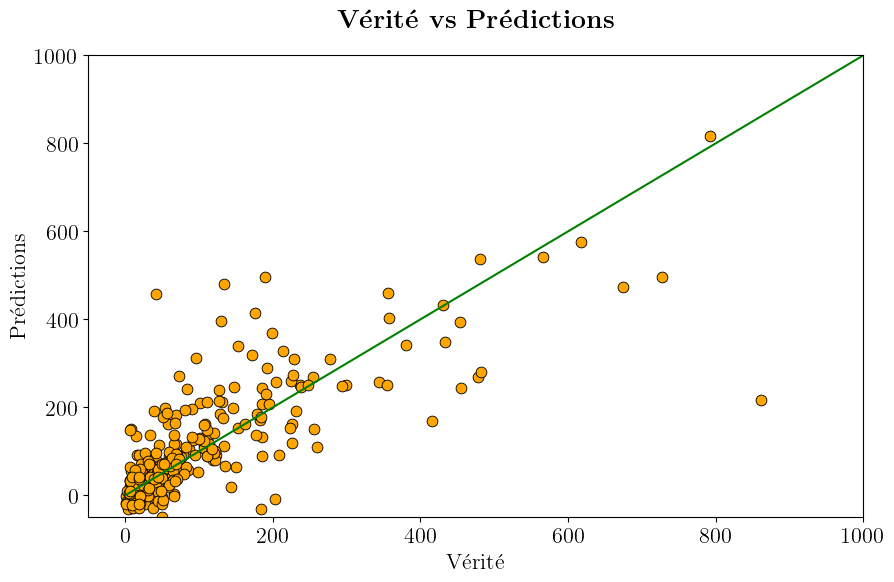

In [188]:
#Scatter-plot predictions vs vérité

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size = 16)


plt.figure(figsize = (10, 6))
sns.scatterplot(x = y_test, y = y_best_pred, color = 'orange', marker='o', edgecolor = 'black', s = 60)
sns.lineplot(x = y_test, y = y_test, color = 'green', linestyle = '-')
plt.xlim(right = 1000, left = -50)
plt.ylim(top = 1000, bottom = -50)

plt.xlabel('Vérité')
plt.ylabel('Prédictions')
plt.title('\\textbf{{Vérité vs Prédictions}}', pad = 20)
plt.savefig(f"scatterplot_true_pred_2.pdf", bbox_inches = 'tight')
plt.show()

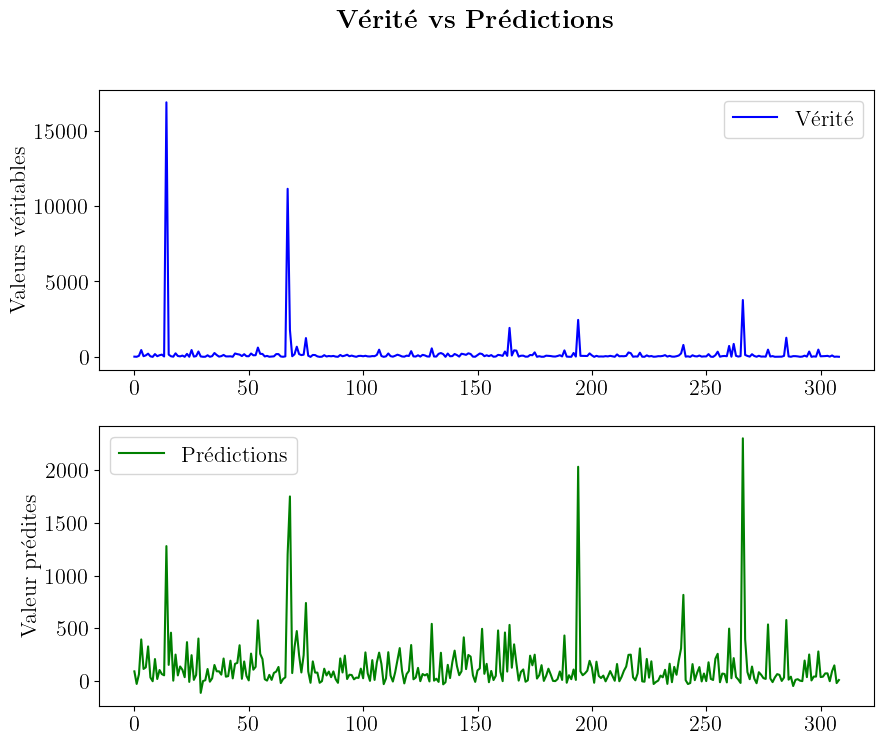

In [190]:
absc = [i for i in range(y_test.shape[0])]

fig, axes = plt.subplots(2,1, figsize = (10,8))
sns.lineplot(x = absc, y = y_test, color = 'blue', ax = axes[0], label = 'Vérité')
sns.lineplot(x = absc, y = y_best_pred, color = 'green', ax = axes[1], label = 'Prédictions')
axes[0].set_ylabel('Valeurs véritables')
axes[1].set_ylabel('Valeur prédites')
plt.suptitle(f"\\textbf{{Vérité vs Prédictions}}")
plt.savefig(f"lineplot_true_pred_2.pdf", bbox_inches = 'tight')
plt.show()

In [192]:
#Pour optimiser le modèle qui ne parvient pas à reproduire sa performance sur le jeu de test, on tente une transformation logarithmique

y_train_log = (y_train + 1).apply(np.log)
y_test_log = (y_test + 1).apply(np.log)

model_xgb_std_optimal.fit(X_train, y_train_log)


#On affiche les scores

print('-'*30)
print('SCORES DE VALIDATION CROISEE')
print('-'*30)
print("R2 Score :", cross_val_score(model_xgb_std_optimal, X_train, y_train_log, cv = 5, scoring="r2", n_jobs = -1).mean().round(2))
print("RMSE Score :", -cross_val_score(model_xgb_std_optimal, X_train, y_train_log, cv = 5, scoring="neg_root_mean_squared_error", n_jobs = -1).mean().round(2))
print("MAE Score :", -cross_val_score(model_xgb_std_optimal, X_train, y_train_log, cv = 5, scoring="neg_mean_absolute_error", n_jobs = -1).mean().round(2))
print('_'*30)

print('\n')

y_best_pred_log = model_xgb_std_optimal.predict(X_test) 

#On calcule les scores
print('-'*30)
print('SCORES SUR LE JEU DE TEST')
print('-'*30)
print('R2 Score :', r2_score(y_test_log, y_best_pred_log).round(2))
print('RMSE Score :', np.sqrt(mean_squared_error(y_test_log, y_best_pred_log)).round(2))
print('MAE Score :', mean_absolute_error(y_test_log, y_best_pred_log).round(2))
print('_'*30)

print('\n')
print("On repasse à l'exponentielle")
print('-'*30)
print('-'*30)
print('SCORES SUR LE JEU DE TEST')
print('-'*30)
print('R2 Score :', r2_score(y_test, np.exp(y_best_pred_log)).round(2))
print('RMSE Score :', np.sqrt(mean_squared_error(y_test, np.exp(y_best_pred_log))).round())
print('MAE Score :', mean_absolute_error(y_test, np.exp(y_best_pred_log)).round())
print('_'*30)

------------------------------
SCORES DE VALIDATION CROISEE
------------------------------
R2 Score : 0.83
RMSE Score : 0.61
MAE Score : 0.46
______________________________


------------------------------
SCORES SUR LE JEU DE TEST
------------------------------
R2 Score : 0.79
RMSE Score : 0.61
MAE Score : 0.45
______________________________


On repasse à l'exponentielle
------------------------------
------------------------------
SCORES SUR LE JEU DE TEST
------------------------------
R2 Score : 0.32
RMSE Score : 976.0
MAE Score : 130.0
______________________________


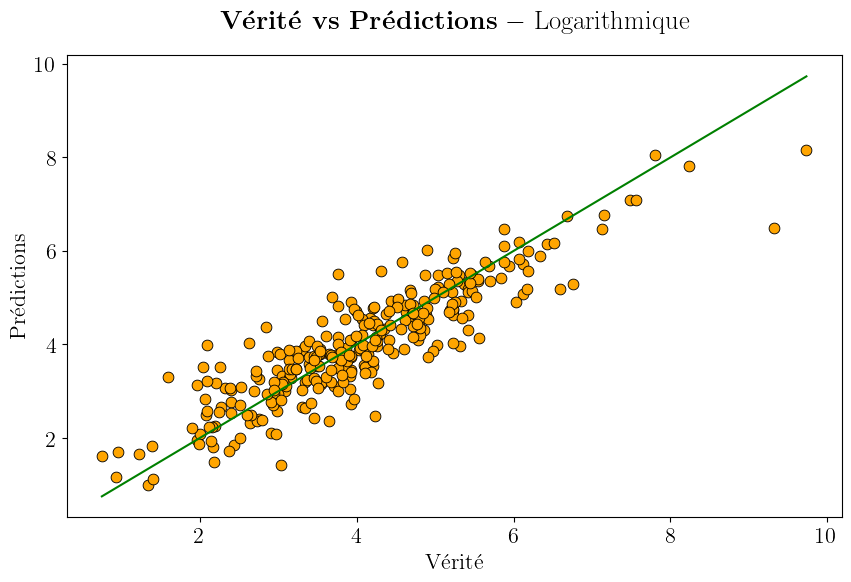

In [194]:
#Scatter-plot predictions vs vérité

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size = 16)


plt.figure(figsize = (10, 6))
sns.scatterplot(x = y_test_log, y = y_best_pred_log, color = 'orange', marker='o', edgecolor = 'black', s = 60)
sns.lineplot(x = y_test_log, y = y_test_log, color = 'green', linestyle = '-')
#plt.xlim(right = 1000, left = -50)
#plt.ylim(top = 1000, bottom = -50)

plt.xlabel('Vérité')
plt.ylabel('Prédictions')
plt.title('\\textbf{{Vérité vs Prédictions}} $-$ Logarithmique', pad = 20)
plt.savefig(f"scatterplot_true_pred_2_log.pdf", bbox_inches = 'tight')
plt.show()

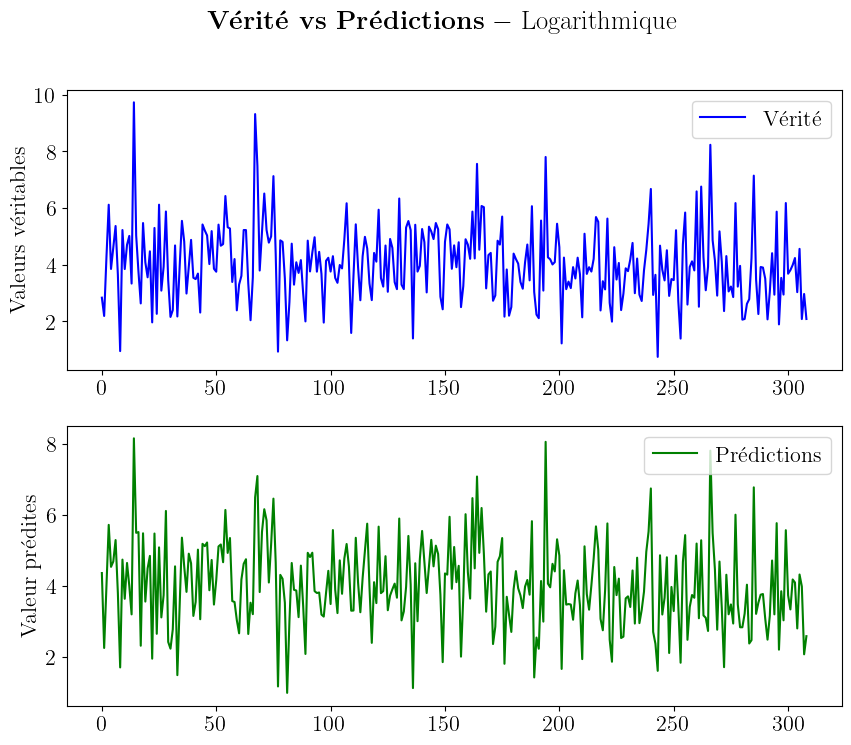

In [196]:
fig, axes = plt.subplots(2,1, figsize = (10,8))
sns.lineplot(x = absc, y = y_test_log, color = 'blue', ax = axes[0], label = 'Vérité')
sns.lineplot(x = absc, y = y_best_pred_log, color = 'green', ax = axes[1], label = 'Prédictions')
axes[0].set_ylabel('Valeurs véritables')
axes[1].set_ylabel('Valeur prédites')
plt.suptitle(f"\\textbf{{Vérité vs Prédictions}} $-$ Logarithmique")
plt.savefig(f"lineplot_true_pred_2_log.pdf", bbox_inches = 'tight')
plt.show()

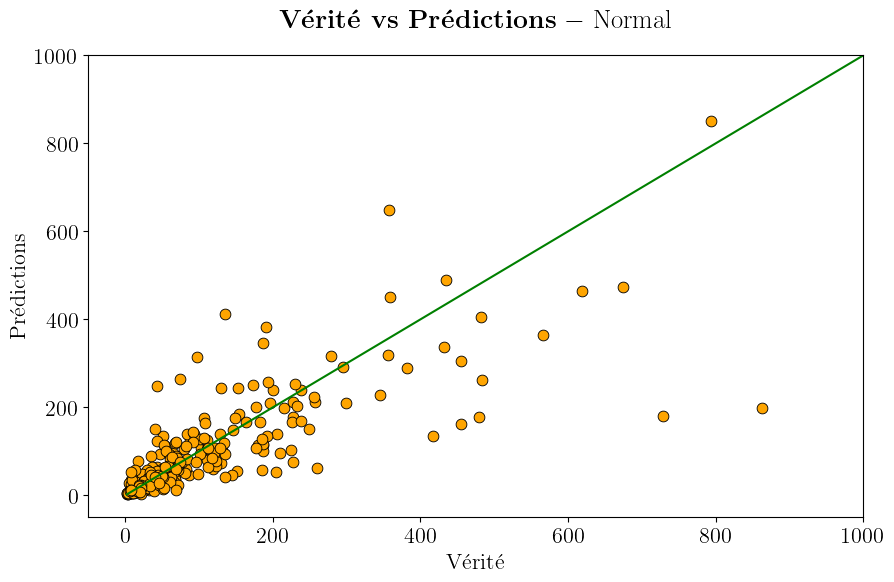

In [198]:
#Scatter-plot predictions vs vérité

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size = 16)


plt.figure(figsize = (10, 6))
sns.scatterplot(x = np.exp(y_test_log), y = np.exp(y_best_pred_log), color = 'orange', marker='o', edgecolor = 'black', s = 60)
sns.lineplot(x = np.exp(y_test_log), y = np.exp(y_test_log), color = 'green', linestyle = '-')
plt.xlim(right = 1000, left = -50)
plt.ylim(top = 1000, bottom = -50)

plt.xlabel('Vérité')
plt.ylabel('Prédictions')
plt.title('\\textbf{{Vérité vs Prédictions}} $-$ Normal', pad = 20)
plt.savefig(f"scatterplot_true_pred_2_logexp.pdf", bbox_inches = 'tight')
plt.show()

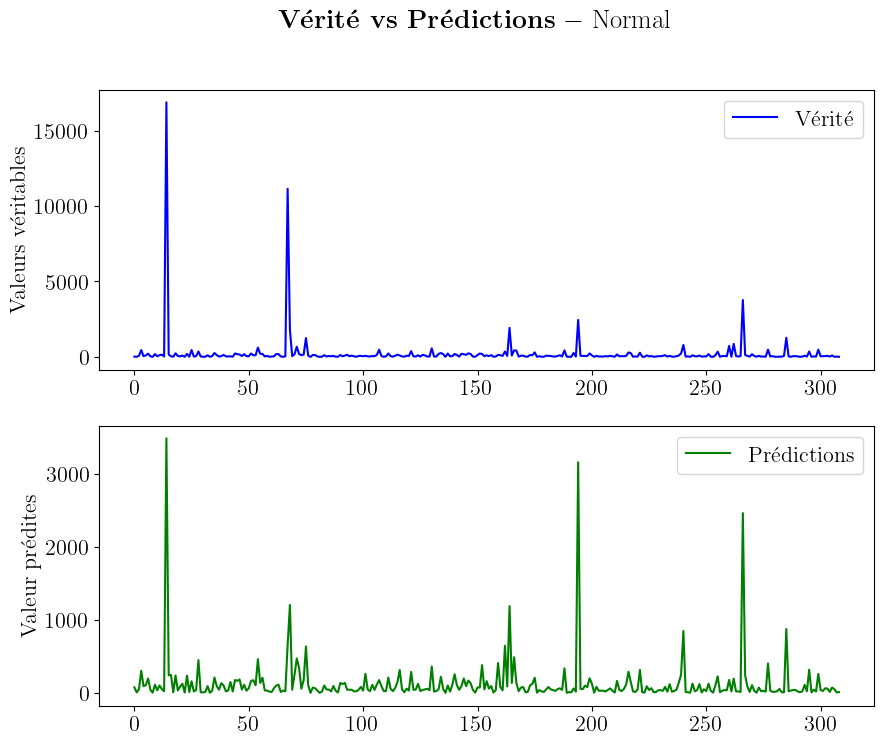

In [200]:
fig, axes = plt.subplots(2,1, figsize = (10,8))
sns.lineplot(x = absc, y = np.exp(y_test_log), color = 'blue', ax = axes[0], label = 'Vérité')
sns.lineplot(x = absc, y = np.exp(y_best_pred_log), color = 'green', ax = axes[1], label = 'Prédictions')
axes[0].set_ylabel('Valeurs véritables')
axes[1].set_ylabel('Valeur prédites')
plt.suptitle(f"\\textbf{{Vérité vs Prédictions}} $-$ Normal")
plt.savefig(f"lineplot_true_pred_2_logexp.pdf", bbox_inches = 'tight')
plt.show()

In [202]:
model = model_xgb_std_optimal

#On récupère le nom des colonnes des données prétraitées dans une liste

feature_names = model.steps[0][1].get_feature_names_out().tolist()
feature_names = [feature.replace('num__', '') for feature in feature_names]
feature_names = [feature.replace('cat__', '') for feature in feature_names]



#On récupère l'importance des features

feature_importances = model.steps[1][1].feature_importances_.tolist()



#On crée un dataframe

data_feature_importance = pd.DataFrame({'FEATURE' : feature_names, 'IMPORTANCE' : feature_importances})

In [204]:
#On regroupe les importances par features pour avoir l'importance de la feature de base

categorical_features = ['PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'Neighborhood']
numerical_features = feature_names[0:10]

sum_importances = []

for feature in categorical_features:
    somme = data_feature_importance.loc[data_feature_importance['FEATURE'].str.contains(feature), 'IMPORTANCE'].sum()
    sum_importances.append(somme)

    
data_sum = pd.DataFrame({'FEATURE' : categorical_features, 'IMPORTANCE' : sum_importances})
data_feature_importance = pd.concat([data_feature_importance.loc[data_feature_importance['FEATURE'].isin(numerical_features),:], data_sum])


#On arrondit, et on trie

data_feature_importance['IMPORTANCE'] = data_feature_importance['IMPORTANCE']*100
data_feature_importance =  data_feature_importance.sort_values(by = 'IMPORTANCE', ascending = False)
data_feature_importance.reset_index(drop = True, inplace = True)

In [206]:
data_feature_importance.loc[data_feature_importance['FEATURE'] == 'Prop_Electricity', 'FEATURE'] = 'ElectricityProp'
data_feature_importance.loc[data_feature_importance['FEATURE'] == 'Prop_Gas', 'FEATURE'] = 'GasProp'
data_feature_importance.loc[data_feature_importance['FEATURE'] == 'Prop_Steam', 'FEATURE'] = 'SteamProp'

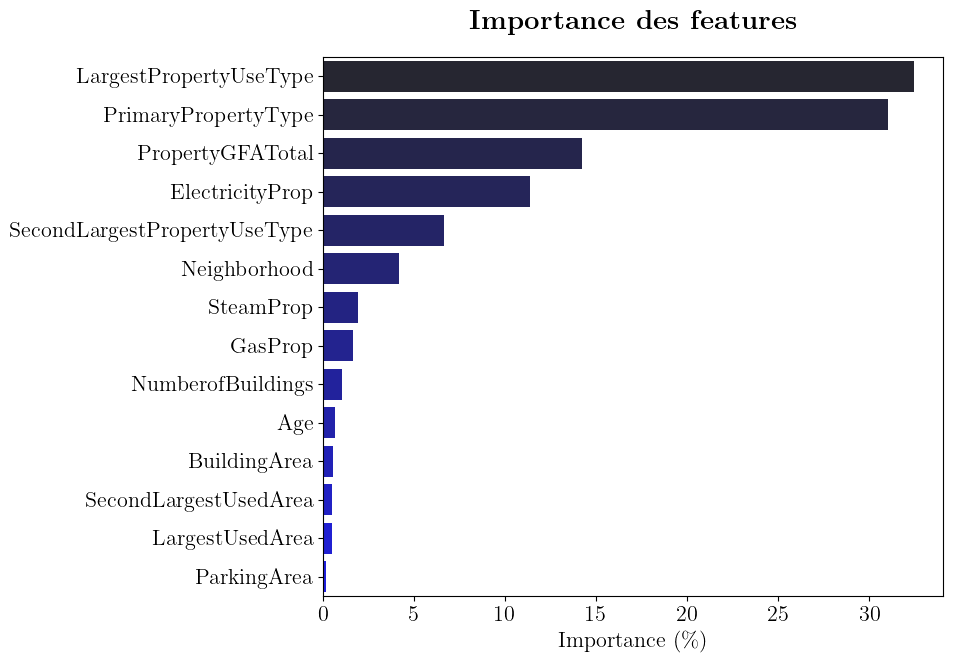

In [208]:
#On plot

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size = 16)

plt.figure(figsize=(8, 7))
sns.barplot(y = 'FEATURE', x = 'IMPORTANCE', hue = 'FEATURE', data = data_feature_importance.head(15), palette = 'dark:blue', legend = False)
plt.xlabel('Importance $(\%)$')
plt.ylabel('')
plt.title('\\textbf{Importance des features}', size = 20, pad = 20)
plt.savefig(f"barplot_feature_importance_2.pdf", bbox_inches = 'tight')
plt.show()

In [210]:
#SHAP

X_train_processed = preprocessor_stdscl.fit_transform(X_train)
X_test_processed = preprocessor_stdscl.transform(X_test)

estimator = model.steps[-1][1]

explainer = shap.Explainer(estimator, X_train_processed.toarray())
explainer.expected_value

9.542444383527503

In [212]:
#Création des SHAP Values

shap_values = explainer(X_test_processed.toarray(), check_additivity = False)


#On les regroupe dans un dataframe

shap_df = pd.DataFrame(shap_values.values, columns = feature_names)

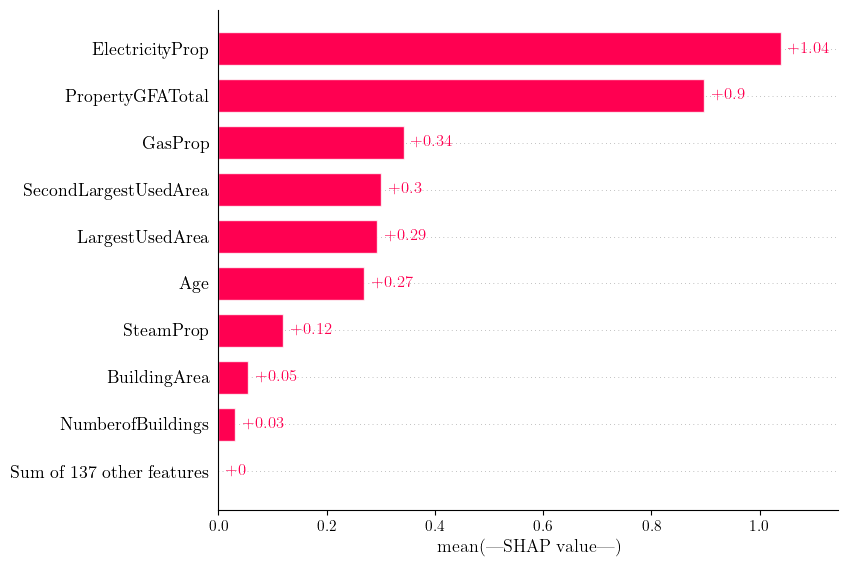

In [214]:
#On plot 
shap_values.feature_names = feature_names
plt.rc('text', usetex = True)
shap.plots.bar(shap_values)

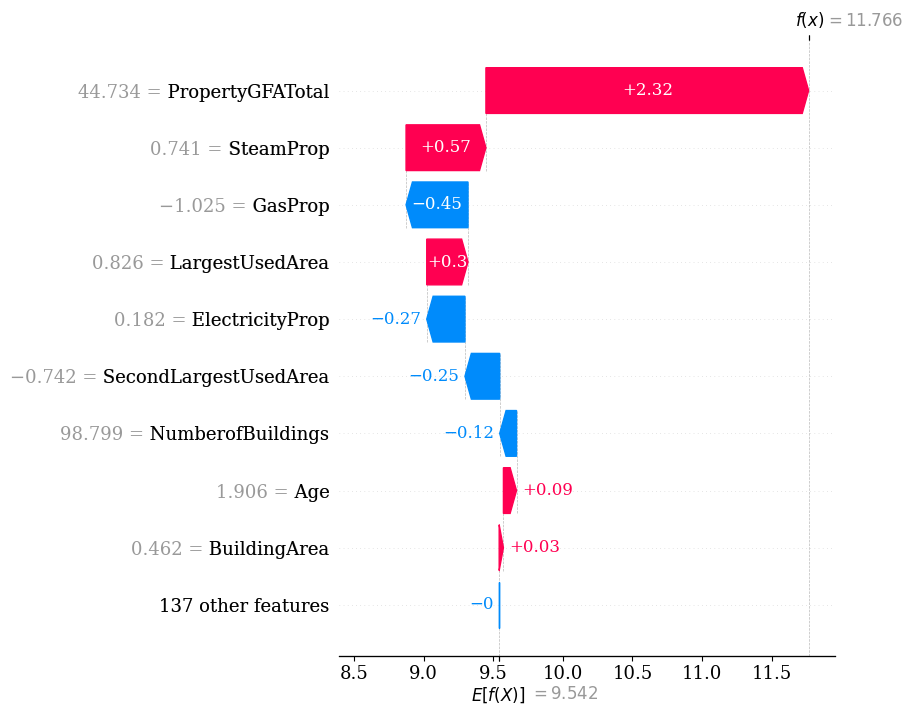

In [228]:
#Diagramme en cascade

i = 67

explanation = shap.Explanation(values=shap_values[i],
                                  base_values = shap_values.base_values,
                                  data=X_star_train.iloc[i], 
                                  feature_names=feature_names)


plt.rc('text', usetex = False)
plt.rc('font', family = 'serif', size = 12)
plt.figure(figsize = (12,9))
shap.waterfall_plot(explanation, show = False)
w, _ = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(w*0.8, w*1)
# Afficher le graphique
plt.show()

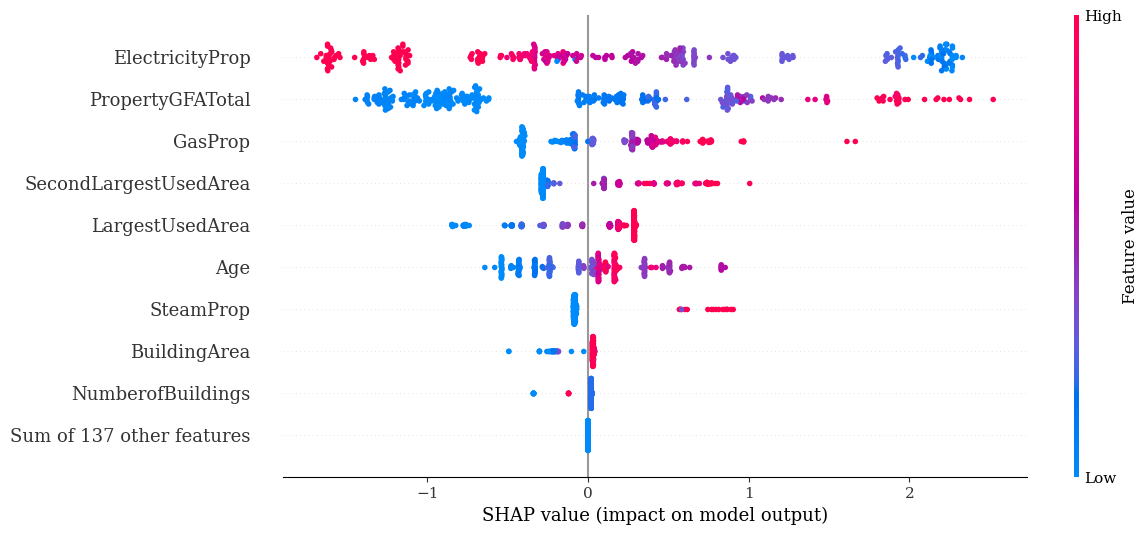

In [218]:
#Diagramme en essaim

shap.plots.beeswarm(shap_values, max_display=10, plot_size = (12,6))

In [220]:
#Diagramme de force

shap.plots.force(shap_values[0:100])